# Building up to Gaussian Processes

In [1]:
# Standard Stuff
import numpy as np
import pandas as pd

# Plotty Stuff
import matplotlib.pyplot as plt
import seaborn as sns

# Testing something
import ipywidgets as widgets

## Build Random Functions From a Prior

Use the squared exponential covariance function:

$\kappa(x_p, x_q) = exp(-\frac{1}{2} (x_p - x_q)^2)$

In [2]:
def kernel_sq(x_i, x_j):
    return np.exp(-0.5*(x_i-x_j)**2)

# Build the covariance matrix (slowly yes but clearly this way...)
# Using the squared exponential covariance function
# k(x1, x2) = exp(-1/2 (x1-x2)^2)
def cov_matrix_fun(x_i, x_j):
    num_i = len(x_i)
    num_j = len(x_j)
    cov_matrix = np.zeros((num_i, num_j))
    for ii in range(num_i):
        for jj in range(num_j):
            cov_value = kernel_sq(x_i[ii], x_j[jj])
            cov_matrix[ii,jj] = cov_value
    return cov_matrix

# Build a test range to work on
x_range = np.arange(-5,5,0.05)
num_x = len(x_range)

# Start with a zero mean
mean_vec = np.zeros(x_range.shape)
        
cov_matrix = cov_matrix_fun(x_range, x_range)

In [3]:
# the pointwise standard deviation ^2 is given by the diagonal of the covariance matrix
np.diag(cov_matrix)

# and pointwise mean is just the mean vec

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

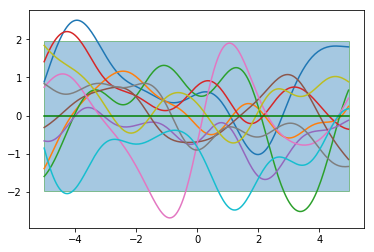

In [10]:
# Draw random vectors from this multivariate gaussian 

n_functions = 100


def plot_gaussian(n_functions):
    prior_df = pd.DataFrame(columns = ['x_range', 'y_range'])
    for ii in range(n_functions):

        y1 = np.random.multivariate_normal(mean_vec, cov_matrix)

        add_df = pd.DataFrame()
        add_df['x_range'] = x_range
        add_df['y_range'] = y1

        prior_df = prior_df.append(add_df)
        # Plot these randomly drawn functions
        if ii%10 == 0:
            plt.plot(x_range, y1)

    # Also show the true mean and covariance of prior
    std_vec = np.sqrt(np.diag(cov_matrix))
    plt.plot(x_range, mean_vec, c='green')
    plt.fill_between(x_range, mean_vec - 1.96*std_vec, mean_vec + 1.96*std_vec, alpha=0.4, edgecolor = 'green')
    #sns.lineplot(x = 'x_range', y = 'y_range', data= prior_df)
    plt.show()
    return prior_df

prior_df = plot_gaussian(100)

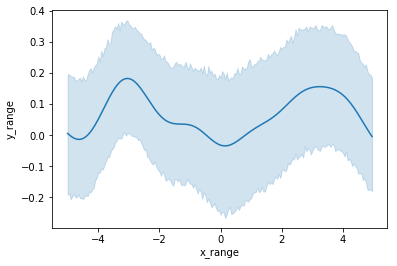

In [11]:
# Show the distribution and mean value for these functions
# mean should be close to 0, with std not dependent on x?
# probably just need way more functions or something
sns.lineplot(x = 'x_range', y = 'y_range', data= prior_df)
plt.show()

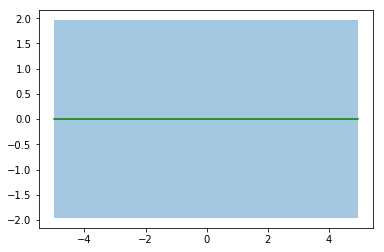

In [12]:
# True mean and covariance of prior
std_vec = np.sqrt(np.diag(cov_matrix))
plt.plot(x_range, mean_vec, c='green')
plt.fill_between(x_range, mean_vec - 1.96*std_vec, mean_vec + 1.96*std_vec, alpha=0.4)
#sns.lineplot(x = 'x_range', y = 'y_range', data= prior_df)
plt.show()

## Prediction with Noise Free Observation

The conditional joint gaussian prior distribution is given by the following:

$f_* | X_*, x, f \sim \mathcal{N} \left(K(X_*, X) K(X, X)^{-1} f, K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*) \right)$

Where $f_*$ is the function at the test points $X_*$, and K the pointwise Kernel matrix between either the training set X or the test points.

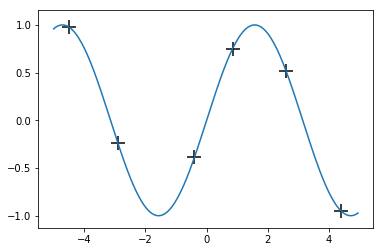

In [13]:
# first create a test function to predict on, grab 5 values from it
f = np.sin(x_range)

idx_train = [10, 42, 92, 117, 152, 188]
x_train = x_range[idx_train]
y_train = f[idx_train]

plt.plot(x_range, f)
plt.scatter(x_train, y_train, marker='+', s=200, c='k')
plt.show()

In [14]:
# produce the prior distribution from which to grab new functions
K_xtest_xtrain = cov_matrix_fun(x_range, x_train)
K_xtrain_xtrain = cov_matrix_fun(x_train, x_train)
K_xtest_xtest = cov_matrix_fun(x_range, x_range)
K_xtrain_xtest = cov_matrix_fun(x_train, x_range)

mean_vec_post = K_xtest_xtrain @ np.linalg.pinv(K_xtrain_xtrain) @ y_train.reshape(-1, 1)
mean_vec_post = mean_vec_post.flatten()

cov_matrix_post = K_xtest_xtest - K_xtest_xtrain @ np.linalg.pinv(K_xtrain_xtrain) @ K_xtrain_xtest



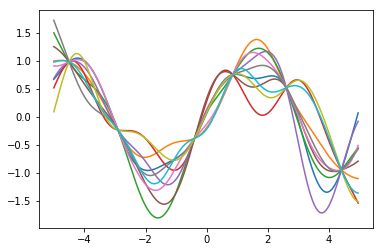

In [15]:
# Draw random vectors from this posterior multivariate gaussian 
n_functions = 100
prior_df = pd.DataFrame(columns = ['x_range', 'y_range'])

for ii in range(n_functions):
    
    y1 = np.random.multivariate_normal(mean_vec_post, cov_matrix_post)
    
    add_df = pd.DataFrame()
    add_df['x_range'] = x_range
    add_df['y_range'] = y1
    
    prior_df = prior_df.append(add_df)
    # Plot these randomly drawn functions
    if ii%10 == 0:
        plt.plot(x_range, y1)

plt.show()

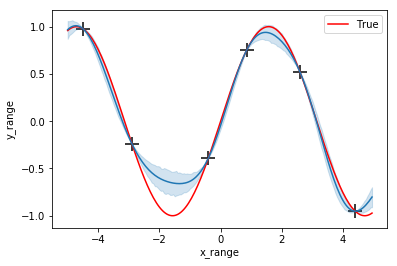

In [16]:
# Show the distribution and mean value for these functions
# compare with true function and given points
plt.plot(x_range, f, c='red', label='True')
#plt.plot(x_range, mean_vec_post, c='green', label='GP Mean')
plt.legend()
plt.scatter(x_train, y_train, marker='+', s=200, c='k')
sns.lineplot(x = 'x_range', y = 'y_range', data= prior_df)
plt.show()

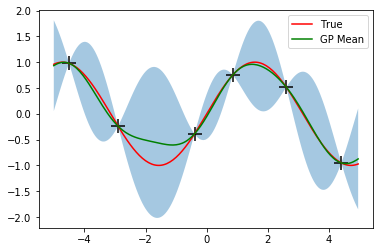

In [17]:
# Show the mean vector together with the pointwise standard deviations
std_vec_post = np.sqrt(np.diag(abs(cov_matrix_post)))
plt.plot(x_range, f, c='red', label='True')
plt.plot(x_range, mean_vec_post, c='green', label='GP Mean')
plt.fill_between(x_range, mean_vec_post - 1.96*std_vec_post, mean_vec_post + 1.96*std_vec_post, alpha=0.4)
plt.legend()
plt.scatter(x_train, y_train, marker='+', s=200, c='k')
#sns.lineplot(x = 'x_range', y = 'y_range', data= prior_df)
plt.show()

## Prediction with Noisy Observation

The conditional joint gaussian prior distribution is now given by the following:

(Essentially $K(X, X) \rightarrow (K(X, X) + \sigma_n^2 I)$ )

$f_* | X_*, x, f \sim \mathcal{N} \left(K(X_*, X)  (K(X, X) + \sigma_n^2 I)^{-1} f, K(X_*, X_*) - K(X_*, X)  (K(X, X) + \sigma_n^2 I)^{-1} K(X, X_*) \right)$

Where $f_*$ is the function at the test points $X_*$, and K the pointwise Kernel matrix between either the training set X or the test points.

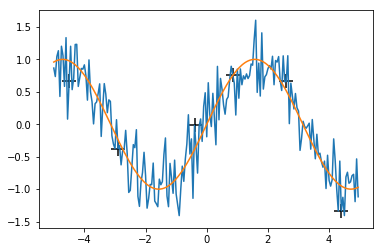

In [18]:
# first create a test function to predict on, grab 5 values from it but now with noise
sigma_n = 0.3
f_noise = np.sin(x_range) + np.random.normal(0, sigma_n, len(x_range))

idx_train = [10, 42, 92, 117, 152, 188]
x_train = x_range[idx_train]
y_train = f_noise[idx_train]

plt.plot(x_range, f_noise)
plt.plot(x_range, f)
plt.scatter(x_train, y_train, marker='+', s=200, c='k')
plt.show()

In [19]:
# produce the prior distribution from which to grab new functions
# note that all we need to alter is K_xtrain_xtrain
K_xtest_xtrain = cov_matrix_fun(x_range, x_train)
K_xtrain_xtrain = cov_matrix_fun(x_train, x_train) + sigma_n**2 * np.eye(len(x_train))
K_xtest_xtest = cov_matrix_fun(x_range, x_range)
K_xtrain_xtest = cov_matrix_fun(x_train, x_range)

mean_vec_post = K_xtest_xtrain @ np.linalg.pinv(K_xtrain_xtrain) @ y_train.reshape(-1, 1)
mean_vec_post = mean_vec_post.flatten()

cov_matrix_post = K_xtest_xtest - K_xtest_xtrain @ np.linalg.pinv(K_xtrain_xtrain) @ K_xtrain_xtest

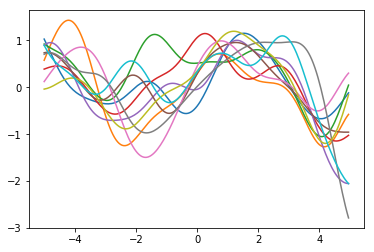

In [20]:
# Draw random vectors from this posterior multivariate gaussian 
n_functions = 100
prior_df = pd.DataFrame(columns = ['x_range', 'y_range'])

for ii in range(n_functions):
    
    y1 = np.random.multivariate_normal(mean_vec_post, cov_matrix_post)
    
    add_df = pd.DataFrame()
    add_df['x_range'] = x_range
    add_df['y_range'] = y1
    
    prior_df = prior_df.append(add_df)
    # Plot these randomly drawn functions
    if ii%10 == 0:
        plt.plot(x_range, y1)

plt.show()

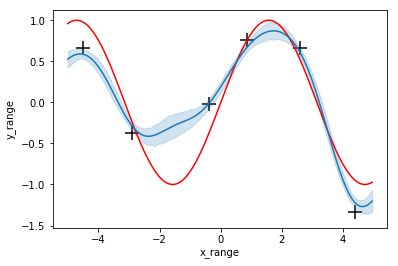

In [21]:
# Show the distribution and mean value for these functions
# compare with true function and given points
plt.plot(x_range, f, c='red')
#plt.plot(x_range, f_noise, c='red')
plt.scatter(x_train, y_train, marker='+', s=200, c='k')
sns.lineplot(x = 'x_range', y = 'y_range', data= prior_df)
plt.show()

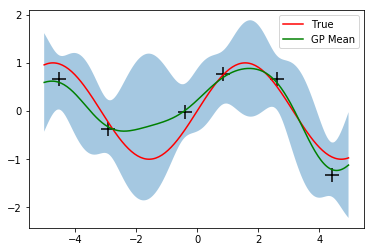

In [22]:
# Show the mean vector together with the pointwise standard deviations
std_vec_post = np.sqrt(np.diag(abs(cov_matrix_post)))
plt.plot(x_range, f, c='red', label='True')
plt.plot(x_range, mean_vec_post, c='green', label='GP Mean')
plt.fill_between(x_range, mean_vec_post - 1.96*std_vec_post, mean_vec_post + 1.96*std_vec_post, alpha=0.4)
plt.legend()
plt.scatter(x_train, y_train, marker='+', s=200, c='k')
#sns.lineplot(x = 'x_range', y = 'y_range', data= prior_df)
plt.show()

## More Complicated Kernels...

We may need to tune hyperparameters for more complicated kernels. The true squared exponential covariance function has three:

$k_y (x_p, x_q) = \sigma_f^2 exp\left( -\frac{1}{2l^2} (x_p - x_q)^2 \right) +\sigma_n^2 \delta_{p,q} $

We can vary:

$\sigma_f$: Signal Variance. for $x_*$ far from any x, $\sigma_{point} \to \sigma_f$

$l$: Length Scale. how 'wiggly' the function is. Small $l$ = more wiggles.

$\sigma_n$: Noise Variance. underlying noise. Increase $\sigma_n$, more slowlying varying solution.

In [31]:
def kernel_sq_1d(x_i, x_j, sigma_f, l, sigma_n):
    ky = sigma_f**2*np.exp(-1/(2*l**2)*(x_i-x_j)**2)
    return ky

def cov_matrix_fun_1d(x_i, x_j, sigma_f, l, sigma_n):
    num_i = len(x_i)
    num_j = len(x_j)
    cov_matrix = np.zeros((num_i, num_j))
    for ii in range(num_i):
        for jj in range(num_j):
            cov_value = kernel_sq_1d(x_i[ii], x_j[jj], sigma_f, l, sigma_n)
            cov_matrix[ii,jj] = cov_value
    return cov_matrix

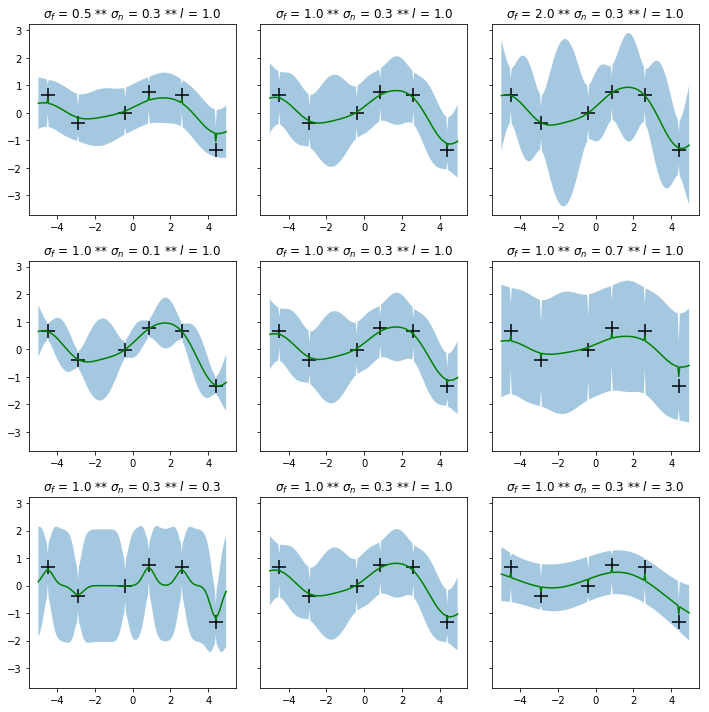

In [48]:
fig, ax = plt.subplots(3,3, figsize=(10,10), sharey=True)
# produce the prior distribution from which to grab new functions
sigma_f_list = [0.5, 1, 2]
sigma_n_list = [0.1, 0.3, 0.7]
l_list = [0.3, 1, 3]

row = 0
sigma_n = 0.3
l = 1
for col, sigma_f in enumerate(sigma_f_list):
    K_xtest_xtrain = cov_matrix_fun_1d(x_range, x_train, sigma_f, l, sigma_n)
    K_xtrain_xtrain = cov_matrix_fun_1d(x_train, x_train, sigma_f, l, sigma_n) + sigma_n**2 * np.eye(len(x_train))
    K_xtest_xtest = cov_matrix_fun_1d(x_range, x_range, sigma_f, l, sigma_n)
    K_xtrain_xtest = cov_matrix_fun_1d(x_train, x_range, sigma_f, l, sigma_n)

    mean_vec_post = K_xtest_xtrain @ np.linalg.pinv(K_xtrain_xtrain) @ y_train.reshape(-1, 1)
    mean_vec_post = mean_vec_post.flatten()
    cov_matrix_post = K_xtest_xtest - K_xtest_xtrain @ np.linalg.pinv(K_xtrain_xtrain) @ K_xtrain_xtest
    std_vec_post = np.sqrt(np.diag(abs(cov_matrix_post)))
    #ax[row, col].plot(x_range, f, c='red', label='True')
    ax[row, col].plot(x_range, mean_vec_post, c='green', label='GP Mean')
    ax[row, col].fill_between(x_range, mean_vec_post - 1.96*std_vec_post, mean_vec_post + 1.96*std_vec_post, alpha=0.4)
    ax[row, col].scatter(x_train, y_train, marker='+', s=200, c='k')
    ax[row, col].set_title(r'$\sigma_f$ = {:0.1f} ** $\sigma_n$ = {:0.1f} ** $l$ = {:0.1f}'.format(sigma_f, sigma_n, l) )


row = 1
sigma_f = 1
l = 1
for col, sigma_n in enumerate(sigma_n_list):
    K_xtest_xtrain = cov_matrix_fun_1d(x_range, x_train, sigma_f, l, sigma_n)
    K_xtrain_xtrain = cov_matrix_fun_1d(x_train, x_train, sigma_f, l, sigma_n) + sigma_n**2 * np.eye(len(x_train))
    K_xtest_xtest = cov_matrix_fun_1d(x_range, x_range, sigma_f, l, sigma_n)
    K_xtrain_xtest = cov_matrix_fun_1d(x_train, x_range, sigma_f, l, sigma_n)

    mean_vec_post = K_xtest_xtrain @ np.linalg.pinv(K_xtrain_xtrain) @ y_train.reshape(-1, 1)
    mean_vec_post = mean_vec_post.flatten()
    cov_matrix_post = K_xtest_xtest - K_xtest_xtrain @ np.linalg.pinv(K_xtrain_xtrain) @ K_xtrain_xtest
    std_vec_post = np.sqrt(np.diag(abs(cov_matrix_post)))
    #ax[row, col].plot(x_range, f, c='red', label='True')
    ax[row, col].plot(x_range, mean_vec_post, c='green', label='GP Mean')
    ax[row, col].fill_between(x_range, mean_vec_post - 1.96*std_vec_post, mean_vec_post + 1.96*std_vec_post, alpha=0.4)
    ax[row, col].scatter(x_train, y_train, marker='+', s=200, c='k')
    ax[row, col].set_title(r'$\sigma_f$ = {:0.1f} ** $\sigma_n$ = {:0.1f} ** $l$ = {:0.1f}'.format(sigma_f, sigma_n, l) )
    

row = 2
sigma_f = 1
sigma_n = 0.3
for col, l in enumerate(l_list):
    K_xtest_xtrain = cov_matrix_fun_1d(x_range, x_train, sigma_f, l, sigma_n)
    K_xtrain_xtrain = cov_matrix_fun_1d(x_train, x_train, sigma_f, l, sigma_n) + sigma_n**2 * np.eye(len(x_train))
    K_xtest_xtest = cov_matrix_fun_1d(x_range, x_range, sigma_f, l, sigma_n)
    K_xtrain_xtest = cov_matrix_fun_1d(x_train, x_range, sigma_f, l, sigma_n)

    mean_vec_post = K_xtest_xtrain @ np.linalg.pinv(K_xtrain_xtrain) @ y_train.reshape(-1, 1)
    mean_vec_post = mean_vec_post.flatten()
    cov_matrix_post = K_xtest_xtest - K_xtest_xtrain @ np.linalg.pinv(K_xtrain_xtrain) @ K_xtrain_xtest
    std_vec_post = np.sqrt(np.diag(abs(cov_matrix_post)))
    #ax[row, col].plot(x_range, f, c='red', label='True')
    ax[row, col].plot(x_range, mean_vec_post, c='green', label='GP Mean')
    ax[row, col].fill_between(x_range, mean_vec_post - 1.96*std_vec_post, mean_vec_post + 1.96*std_vec_post, alpha=0.4)
    ax[row, col].scatter(x_train, y_train, marker='+', s=200, c='k')
    ax[row, col].set_title(r'$\sigma_f$ = {:0.1f} ** $\sigma_n$ = {:0.1f} ** $l$ = {:0.1f}'.format(sigma_f, sigma_n, l) )
    
fig.tight_layout()
plt.show()

## Matern Covariance Function

Related to the squared exponential.

In [52]:
def k_matern_52(x_i, x_j, l):
    r = np.abs(x_i-x_j)
    return (1+np.sqrt(5)*r/l + 5*r**2/(3*l**2))*np.exp(-np.sqrt(5)*r/l)

def cov_matrix_fun_matern(x_i, x_j, l, sigma_n):
    num_i = len(x_i)
    num_j = len(x_j)
    cov_matrix = np.zeros((num_i, num_j))
    for ii in range(num_i):
        for jj in range(num_j):
            cov_value = k_matern_52(x_i[ii], x_j[jj], l)
            cov_matrix[ii,jj] = cov_value
    return cov_matrix

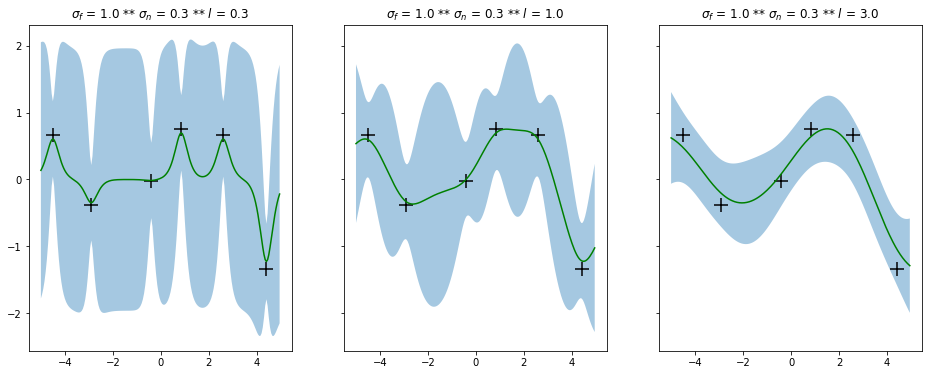

In [57]:
fig, ax = plt.subplots(1,3, figsize=(16,6), sharey=True)
# produce the prior distribution from which to grab new functions
l_list = [0.3, 1, 3]

row = 0
sigma_n = 0.3
for col, l in enumerate(l_list):
    K_xtest_xtrain = cov_matrix_fun_matern(x_range, x_train, l, sigma_n)
    K_xtrain_xtrain = cov_matrix_fun_matern(x_train, x_train, l, sigma_n) + sigma_n**2 * np.eye(len(x_train))
    K_xtest_xtest = cov_matrix_fun_matern(x_range, x_range, l, sigma_n)
    K_xtrain_xtest = cov_matrix_fun_matern(x_train, x_range, l, sigma_n)

    mean_vec_post = K_xtest_xtrain @ np.linalg.pinv(K_xtrain_xtrain) @ y_train.reshape(-1, 1)
    mean_vec_post = mean_vec_post.flatten()
    cov_matrix_post = K_xtest_xtest - K_xtest_xtrain @ np.linalg.pinv(K_xtrain_xtrain) @ K_xtrain_xtest
    std_vec_post = np.sqrt(np.diag(abs(cov_matrix_post)))
    #ax[row, col].plot(x_range, f, c='red', label='True')
    ax[col].plot(x_range, mean_vec_post, c='green', label='GP Mean')
    ax[col].fill_between(x_range, mean_vec_post - 1.96*std_vec_post, mean_vec_post + 1.96*std_vec_post, alpha=0.4)
    ax[col].scatter(x_train, y_train, marker='+', s=200, c='k')
    ax[col].set_title(r'$\sigma_f$ = {:0.1f} ** $\sigma_n$ = {:0.1f} ** $l$ = {:0.1f}'.format(sigma_f, sigma_n, l) )

plt.show()